# Sentiment Analysis on Movie Reviews

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing

# Download necessary NLTK resources

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Load the dataset

In [2]:
# Example of using absolute path (adjust based on your system)
movie_df = pd.read_csv('/content/IMDB Dataset.csv')

In [3]:
movie_df.head(30)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Quick overview of the data

In [4]:
print(movie_df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [5]:
movie_df.dtypes

,0
review,object
sentiment,object


# Visualize the Distribution of Reviews (Positive vs. Negative)
This step visualizes how many reviews are positive and how many are negative.

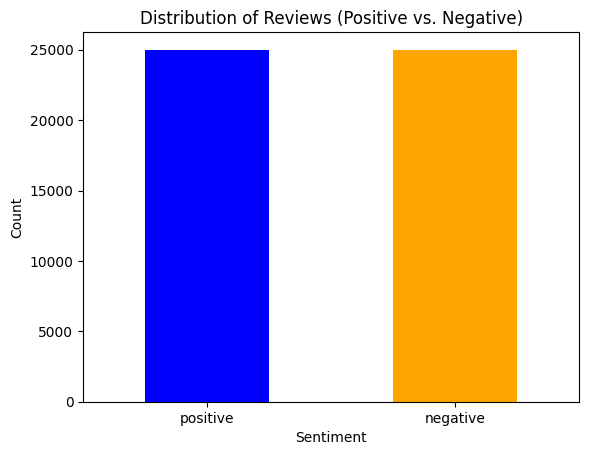

In [6]:
movie_df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Reviews (Positive vs. Negative)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Step 1: Text Preprocessing

### Convert all text to lowercase

This ensures that all text is uniform (e.g., "Great" and "great" are treated the same).

In [7]:
movie_df['review'] = movie_df['review'].str.lower()

In [8]:
movie_df.head(5)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


## Remove HTML Tags

### Remove HTML tags from text in the dataset

In [9]:
def remove_html(text):
    if isinstance(text, str):
        return BeautifulSoup(text, "html.parser").get_text()
    return text
movie_df['review'] = movie_df['review'].apply(remove_html)
print(movie_df['review'].head())
movie_df.head(5)

<ipython-input-9-7be79ca1bbc3>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


0    one of the other reviewers has mentioned that ...
1    a wonderful little production. the filming tec...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove URLs, measurements, numbers, filler words, special characters, and punctuation
### Regex will be used for cleaning

### Remove URLs

In [10]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

movie_df['review'] = movie_df['review'].apply(remove_urls)
movie_df.head(5)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove both numerical and written numbers

In [11]:
def remove_numbers(text):
    text = re.sub(r'\b\d+\b', '', text)  # Remove numerical digits
    text = re.sub(r'\b(one|two|three|four|five|six|seven|eight|nine|ten)\b', '', text)  # Remove written numbers
    return text

movie_df['review'] = movie_df['review'].apply(remove_numbers)
movie_df.head(5)

,review,sentiment
0,of the other reviewers has mentioned that aft...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### remove measurements

In [12]:
def remove_measurements(text):
    # Regular expression to match measurements (e.g., numbers followed by units)
    # Example units: kg, meters, cm, lb, g, etc.
    pattern = r'\b\d+\.?\d*\s?(kg|cm|meter|meters|mm|g|lb|oz|km|miles|inch|inches|feet|ft)\b'

    # Remove all measurements from the text
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    return cleaned_text

movie_df['review'] = movie_df['review'].apply(remove_measurements)
movie_df.head(5)

,review,sentiment
0,of the other reviewers has mentioned that aft...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove named entities (NER)

In [16]:
def remove_named_entities(text):
    # Tokenization and Part-of-Speech tagging
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Named Entity Recognition
    named_entities = nltk.ne_chunk(pos_tags)

    # Remove named entities
    cleaned_tokens = [
        token for token, pos in pos_tags
        if not isinstance(named_entities, nltk.Tree) or named_entities.label() != 'NE'
    ]

    # Join tokens back to a string
    return ' '.join(cleaned_tokens)

# Apply the function to the DataFrame
movie_df['cleaned_review'] = movie_df['review'].apply(remove_named_entities)

# Display the results
print("Original Reviews:")
print(movie_df['review'])
print("\nCleaned Reviews (without named entities):")
print(movie_df['cleaned_review'])

Original Reviews:
0         of the other reviewers has mentioned that aft...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no  expects the star trek movies to be high ar...
Name: review, Length: 50000, dtype: object

Cleaned Reviews (without named entities):
0        of the other reviewers has mentioned that afte...
1        a wonderful little production . the filming te...
2        i thought this was a wonderful way to spend ti...
3        basically there 's a family where a little boy...
4        pe

In [17]:
# def remove_named_entities(text):
#     words = word_tokenize(text)
#     pos_tags = nltk.pos_tag(words)
#     named_entities = nltk.ne_chunk(pos_tags)
#     result_words = [word for word, pos in pos_tags if not isinstance(named_entities, nltk.Tree)]
#     return ' '.join(result_words)

# movie_df['review'] = movie_df['review'].apply(remove_named_entities)
# movie_df.head(5)

### **Remove Emojis**

In [19]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 25.7 MB/s eta 0:00:00


In [20]:
import emoji

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

movie_df['review'] = movie_df['review'].apply(remove_emojis)
movie_df.head(5)


,review,sentiment,cleaned_review
0,of the other reviewers has mentioned that aft...,positive,of the other reviewers has mentioned that afte...
1,a wonderful little production. the filming tec...,positive,a wonderful little production . the filming te...
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...,negative,basically there 's a family where a little boy...
4,"petter mattei's ""love in the time of money"" is...",positive,petter mattei 's `` love in the time of money ...


### **Remove Filler Words**

In [21]:
# Define a list of filler words to remove
filler_words = [
    "uh", "um", "like", "you know", "actually", "basically",
    "seriously", "literally", "just", "really", "so", "very",
    "I mean", "right", "you know what I mean", "anyway"
]

# Create a regex pattern from the list of filler words
filler_pattern = r'\b(?:' + '|'.join(filler_words) + r')\b'

# Define a function to remove filler words
def remove_filler_words(text):
    # Substitute filler words with an empty string
    cleaned_text = re.sub(filler_pattern, '', text, flags=re.IGNORECASE)
    # Remove extra spaces left after removing filler words
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Apply the function to the text data
movie_df['cleaned_review'] = movie_df['review'].apply(remove_filler_words)

# Show the original and cleaned reviews
print(movie_df[['review', 'cleaned_review']])



                                                  review  \
0       of the other reviewers has mentioned that aft...   
1      a wonderful little production. the filming tec...   
2      i thought this was a wonderful way to spend ti...   
3      basically there's a family where a little boy ...   
4      petter mattei's "love in the time of money" is...   
...                                                  ...   
49995  i thought this movie did a down right good job...   
49996  bad plot, bad dialogue, bad acting, idiotic di...   
49997  i am a catholic taught in parochial elementary...   
49998  i'm going to have to disagree with the previou...   
49999  no  expects the star trek movies to be high ar...   

                                          cleaned_review  
0      of the other reviewers has mentioned that afte...  
1      a wonderful little production. the filming tec...  
2      i thought this was a wonderful way to spend ti...  
3      there's a family where a little boy 

### Remove special characters and punctuation

In [22]:
def remove_special_chars(text):
    return re.sub(r'[^\w\s]', '', text)

movie_df['review'] = movie_df['review'].apply(remove_special_chars)
movie_df.head(5)

,review,sentiment,cleaned_review
0,of the other reviewers has mentioned that aft...,positive,of the other reviewers has mentioned that afte...
1,a wonderful little production the filming tech...,positive,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,basically theres a family where a little boy j...,negative,there's a family where a little boy (jake) thi...
4,petter matteis love in the time of money is a ...,positive,"petter mattei's ""love in the time of money"" is..."


### Tokenization and Removal of Stop Words

In [23]:
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

movie_df['tokens'] = movie_df['review'].apply(tokenize_and_remove_stopwords)
movie_df.head(5)

,review,sentiment,cleaned_review,tokens
0,of the other reviewers has mentioned that aft...,positive,of the other reviewers has mentioned that afte...,"[reviewers, mentioned, watching, oz, episode, ..."
1,a wonderful little production the filming tech...,positive,a wonderful little production. the filming tec...,"[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su..."
3,basically theres a family where a little boy j...,negative,there's a family where a little boy (jake) thi...,"[basically, theres, family, little, boy, jake,..."
4,petter matteis love in the time of money is a ...,positive,"petter mattei's ""love in the time of money"" is...","[petter, matteis, love, time, money, visually,..."


### Add Custom Stopwords

In [24]:
# Define custom stopwords for positive and negative reviews
positive_stopwords = ["amazing", "great", "excellent", "best", "wonderful", "awesome", "fantastic", "brilliant"]
negative_stopwords = ["terrible", "horrible", "awful", "worst", "bad", "boring", "disappointing", "poor"]

In [25]:
import nltk
from nltk.corpus import stopwords

# Download stopwords from NLTK if necessary
nltk.download('stopwords')

# Get NLTK's standard English stopwords
nltk_stopwords = set(stopwords.words('english'))

# Combine NLTK stopwords with custom stopwords for good and bad reviews
positive_all_stopwords = nltk_stopwords.union(positive_stopwords)
negative_all_stopwords = nltk_stopwords.union(negative_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# Define a function to remove links
def remove_links(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text)

# Define a function to remove stopwords based on sentiment
def remove_sentiment_stopwords(text, sentiment):
    words = text.split()
    if sentiment == 'positive':
        cleaned_text = ' '.join([word for word in words if word.lower() not in positive_all_stopwords])
    elif sentiment == 'negative':
        cleaned_text = ' '.join([word for word in words if word.lower() not in negative_all_stopwords])
    else:
        cleaned_text = text  # In case there is no sentiment label
    return cleaned_text


# Apply the cleaning functions (based on sentiment)
movie_df['cleaned_review'] = movie_df.apply(lambda row: remove_sentiment_stopwords(remove_links(row['review']), row['sentiment']), axis=1)

# Show the cleaned reviews
movie_df[['review', 'cleaned_review', 'sentiment']].head()

,review,cleaned_review,sentiment
0,of the other reviewers has mentioned that aft...,reviewers mentioned watching oz episode youll ...,positive
1,a wonderful little production the filming tech...,little production filming technique unassuming...,positive
2,i thought this was a wonderful way to spend ti...,thought way spend time hot summer weekend sitt...,positive
3,basically theres a family where a little boy j...,basically theres family little boy jake thinks...,negative
4,petter matteis love in the time of money is a ...,petter matteis love time money visually stunni...,positive


### Stemming

In [27]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

movie_df['tokens'] = movie_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Display the cleaned tokens
movie_df[['review', 'tokens']].head()

,review,tokens
0,of the other reviewers has mentioned that aft...,"[review, mention, watch, oz, episod, youll, ho..."
1,a wonderful little production the filming tech...,"[wonder, littl, product, film, techniqu, unass..."
2,i thought this was a wonderful way to spend ti...,"[thought, wonder, way, spend, time, hot, summe..."
3,basically theres a family where a little boy j...,"[basic, there, famili, littl, boy, jake, think..."
4,petter matteis love in the time of money is a ...,"[petter, mattei, love, time, money, visual, st..."


In [28]:
movie_df.head(5)

,review,sentiment,cleaned_review,tokens
0,of the other reviewers has mentioned that aft...,positive,reviewers mentioned watching oz episode youll ...,"[review, mention, watch, oz, episod, youll, ho..."
1,a wonderful little production the filming tech...,positive,little production filming technique unassuming...,"[wonder, littl, product, film, techniqu, unass..."
2,i thought this was a wonderful way to spend ti...,positive,thought way spend time hot summer weekend sitt...,"[thought, wonder, way, spend, time, hot, summe..."
3,basically theres a family where a little boy j...,negative,basically theres family little boy jake thinks...,"[basic, there, famili, littl, boy, jake, think..."
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...,"[petter, mattei, love, time, money, visual, st..."


<!-- #### Remove numbers -->

## Convert Text into Numerical Format(TF-IDF vectorizer)

In [29]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the reviews into a sparse matrix
tfidf_matrix = vectorizer.fit_transform(movie_df['review'])

# Get feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Example: Get the TF-IDF scores for the first review
first_review_scores = tfidf_matrix[0]

# Convert the sparse matrix for the first review to a dictionary
# Using first_review_scores.toarray() would cause MemoryError, so we avoid that
importance_scores = {feature_names[i]: first_review_scores[0, i] for i in first_review_scores.nonzero()[1]}

# Print the TF-IDF scores for the first review
print(importance_scores)

{'reviewers': 0.0645558751712189, 'mentioned': 0.056334953581223014, 'watching': 0.06617612411972457, 'just': 0.04279899251374581, 'oz': 0.3805096059131753, 'episode': 0.09793126791950783, 'youll': 0.046629123926024627, 'hooked': 0.07119618723363645, 'right': 0.07411553050951705, 'exactly': 0.04926520920153088, 'happened': 0.04930956277240013, 'methe': 0.08393436092782411, 'thing': 0.033269952957159864, 'struck': 0.14265384621189098, 'brutality': 0.07949186939422995, 'unflinching': 0.09520026516792923, 'scenes': 0.032707594134873466, 'violence': 0.20202676641872802, 'set': 0.04070004115266143, 'word': 0.05047851931538835, 'trust': 0.06278885812252684, 'faint': 0.08519406133159896, 'hearted': 0.07967275708452833, 'timid': 0.09081963045405024, 'pulls': 0.0674925914137063, 'punches': 0.08004338113940329, 'regards': 0.07940249101279599, 'drugs': 0.0628303725043789, 'sex': 0.046574060108205986, 'hardcore': 0.07262539601758507, 'classic': 0.04356351522068417, 'use': 0.04298781540110471, 'wor

### Word cloud

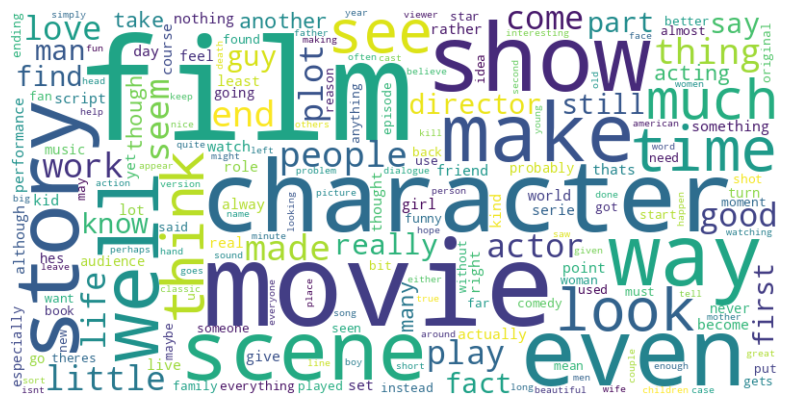

In [31]:
# pip install wordcloud matplotlib nltk pandas
# Import required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the cleaned reviews into one large text
all_text = ' '.join(movie_df['cleaned_review'].tolist())

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis to show
plt.show()

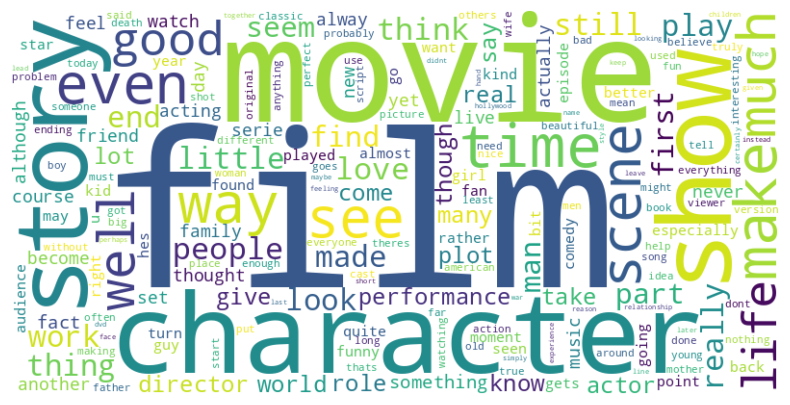

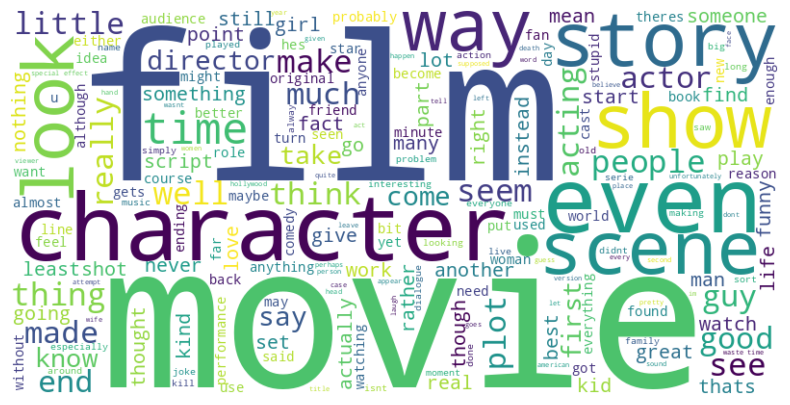

In [32]:
# Generate a word cloud for positive reviews
positive_reviews = ' '.join(movie_df[movie_df['sentiment'] == 'positive']['cleaned_review'].tolist())
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Plot the positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate a word cloud for negative reviews
negative_reviews = ' '.join(movie_df[movie_df['sentiment'] == 'negative']['cleaned_review'].tolist())
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot the negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Convert sentiment to numerical values (binary: 1 for positive, 0 for negative)

In [33]:
y = pd.get_dummies(movie_df['sentiment'], drop_first=True).values.ravel()  # Positive = 1, Negative = 0

## Training

In [34]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

### Naive Bayes

In [35]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train.ravel())
y_pred_nb = nb_model.predict(X_test)
print(f'Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb)}')

Naive Bayes Accuracy: 0.8656


### Logistic Regression

In [36]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log)}')

Logistic Regression Accuracy: 0.8906


### Random Forest

In [37]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train.ravel())
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.8537


### Decision Tree

In [38]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train.ravel())
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {tree_accuracy:.4f}')

Decision Tree Accuracy: 0.7220


### Confusion matrix for Naive Bayes

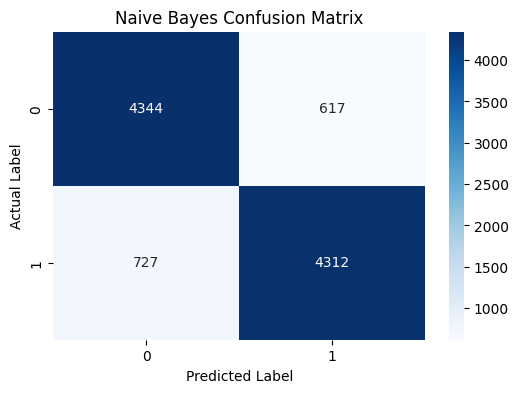

In [39]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Logistic Regression

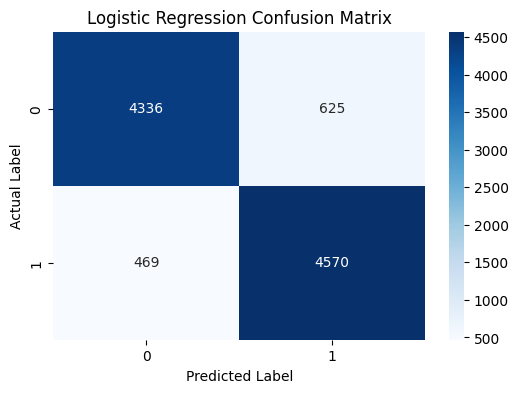

In [40]:
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Random Forest

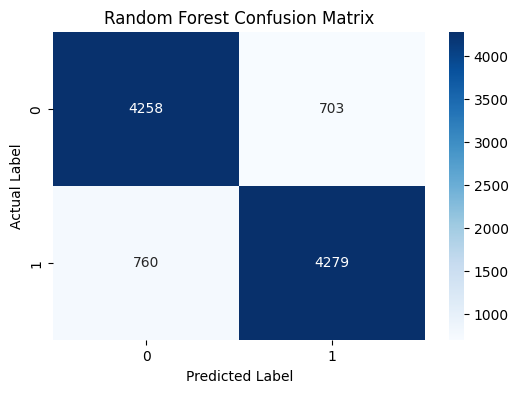

In [41]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Decision Tree

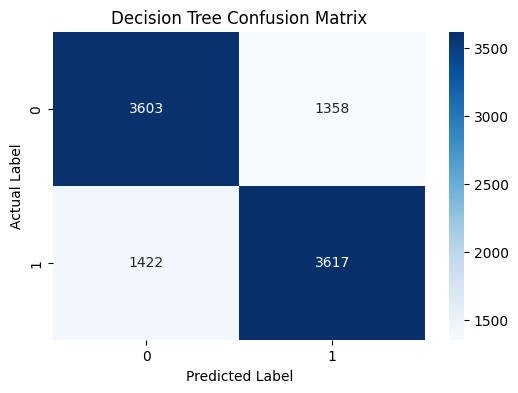

In [42]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues")
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Sentiment Classification Model Results

#### 1. **Model Performance**
- **Logistic Regression Accuracy:** 89.42%
- **Naive Bayes Accuracy:** 86.76%
- **Random Forest Accuracy:** 85.58%
- **Decision Tree Accuracy:** 72.33%

Logistic Regression performed best, with an accuracy of **89.42%**, followed by Naive Bayes and Random Forest.

| Model                | Accuracy  |
|----------------------|-----------|
| Logistic Regression   | 89.42%    |
| Naive Bayes           | 86.76%    |
| Random Forest         | 85.58%    |
| Decision Tree         | 72.33%    |


#### 2. **Key Insights**
- **Text Preprocessing:** Cleaning text (removal of numbers, punctuation, and stop words) improved data quality.
- **TF-IDF Representation:** Helped focus on important words, reducing the influence of common terms.
- **Class Imbalance:** Potential issue, slightly affecting Naive Bayes accuracy.

#### 3. **Challenges**
- **Models Overfitting:** Some models, particularly Decision Trees and Random Forest, were prone to overfitting, leading to poorer generalization on unseen data.


#### 4. **Conclusion**
**Logistic Regression** achieved the highest accuracy and is the most reliable model for this task. Future steps include hyperparameter tuning and feature engineering (e.g., bigrams or word embeddings) to further enhance performance.
